# Semantic Segmentation


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>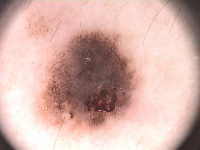</td><td>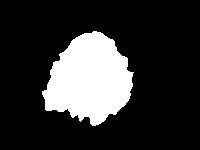</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [0]:
! wget https://www.dropbox.com/s/4q6kwg8de56eqnc/PH2Dataset.rar

--2020-06-07 19:39:20--  https://www.dropbox.com/s/4q6kwg8de56eqnc/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.1, 2620:100:6023:1::a27d:4301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/4q6kwg8de56eqnc/PH2Dataset.rar [following]
--2020-06-07 19:39:20--  https://www.dropbox.com/s/raw/4q6kwg8de56eqnc/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce5da05595ad91a65bf136f8fbf.dl.dropboxusercontent.com/cd/0/inline/A5MtWBGmEJKY0wFjOt7Fd-sJtUqkyKeIm6TJQMyUkpF2o_q_yOX94QShO-lZaFJDLgVK2yEc3QQjORXRr__aqF6FJNCeHZ3hhu-cRdlYsCTygAUQ2MC-zN660Ykv5i5MnDY/file# [following]
--2020-06-07 19:39:21--  https://uce5da05595ad91a65bf136f8fbf.dl.dropboxusercontent.com/cd/0/inline/A5MtWBGmEJKY0wFjOt7Fd-sJtUqkyKeIm6TJQMyUkpF2o_q_yOX94QShO-lZaFJDLgVK2yEc3QQjORXRr__aqF6FJNCeHZ3hhu-cRdlYs

In [0]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [0]:
images = []
lesions = []
from skimage.io import imread
import os
root = '/content/gdrive/My Drive/PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [0]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [0]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

In [0]:
len(lesions)

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

In [0]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [0]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [0]:
print(len(tr), len(val), len(ts))

#### PyTorch DataLoader

In [0]:
import random
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

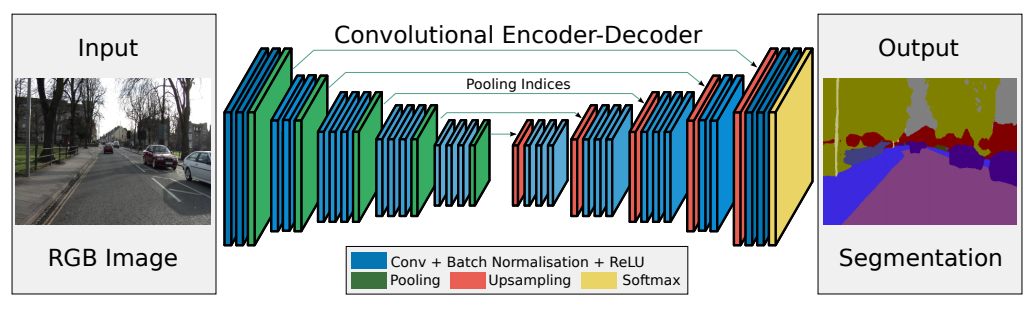

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [0]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32)
            )
        self.enc_conv0_1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32)
            )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
            )
        self.enc_conv1_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
            )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128)
            )
        self.enc_conv2_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128)
            )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256)
            )
        self.enc_conv3_1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256)
            )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # bottleneck
        self.bottleneck_conv =  nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear') # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128)
            )
        self.dec_conv0_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128)
            )
        
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear')# 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
            )
        self.dec_conv1_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
            )


        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear')  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32)
            )
        self.dec_conv2_1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32)
            )

        
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear')  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16)
            )
        self.dec_conv3_1 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)


    def forward(self, x):
        # encoder
        
        e0 = self.pool0(F.relu(self.enc_conv0_1(F.relu(self.enc_conv0(x)))))
        e1 = self.pool1(F.relu(self.enc_conv1_1(F.relu(self.enc_conv1(e0)))))
        e2 = self.pool2(F.relu(self.enc_conv2_1(F.relu(self.enc_conv2(e1)))))
        e3 = self.pool3(F.relu(self.enc_conv3_1(F.relu(self.enc_conv3(e2)))))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0_1(F.relu(self.dec_conv0(self.upsample0(b)))))
        d1 = F.relu(self.dec_conv1_1(F.relu(self.dec_conv1(self.upsample1(d0)))))
        d2 = F.relu(self.dec_conv2_1(F.relu(self.dec_conv2(self.upsample2(d1)))))
        d3 = self.dec_conv3_1(F.relu(self.dec_conv3(self.upsample3(d2))))
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [0]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## функция лосса [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [0]:
def bce_loss(y_real, y_pred):
    return torch.mean( y_pred - y_pred * y_real + torch.log(1. + torch.exp(-1*y_pred) ))# TODO 
    #return torch.mean(torch.clamp(y_pred, 0) - y_pred*y_real + torch.log(1 + torch.exp(-torch.abs(y_pred))))
    # please don't use nn.BCELoss. write it from scratch

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [0]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    losses_tr = []
    losses_val = []
    X_val, Y_val = next(iter(data_val))
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        val_avg_loss = 0

        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        #losses.append(avg_loss)
        toc = time()
        print('loss: %f' % avg_loss)
        losses_tr.append(avg_loss.item())

        # show intermediate results
        model.eval()  # testing mode
        X_batch_hat = X_batch.detach().to('cpu')
        Y_train_hat = Y_batch.detach().to('cpu')
        Y_hat = Y_pred.detach().  to('cpu') # detach and put into cpu

        with torch.no_grad():
          for X_batch, Y_batch in data_val:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            val_avg_loss += loss / len(data_val)
        losses_val.append(val_avg_loss)
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_batch_hat[k].numpy(), 0, 3), cmap='gray') #bug!!!
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_train_hat[k, 0], cmap='gray')
            plt.title('Expected mask')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_hat[k, 0], cmap='gray')            
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    return losses_tr, losses_val

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [0]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [0]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        scores += metric(Y_pred > 0.5, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

In [0]:
model = SegNet().to(device)

In [0]:
device

device(type='cuda')

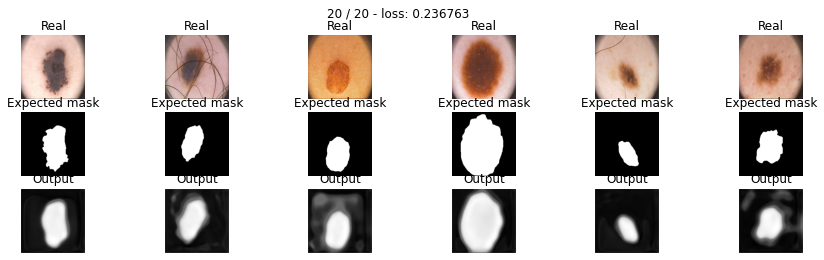

In [0]:
max_epochs = 20
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001)
segnet_bce = train(model, optimizer, bce_loss, max_epochs, data_tr, data_val)

In [0]:
score_model(model, iou_pytorch, data_val)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.6900000095367431

In [0]:
#segnet_bce

-----------------------------------------------------------------------------------------

## Дополнительные функции лосса [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

//  Не забудьте подумать о численной нестабильности.


In [0]:
def dice_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    num = torch.sum((2*y_real*y_pred), dim=(2,3))
    den = torch.sum((y_real+y_pred), dim=(2,3))
    res = 1 - ((num) / (den + 1)).mean()
    return res 

Проводим тестирование:

In [0]:
model_dice = SegNet().to(device)

In [0]:
device

device(type='cuda')

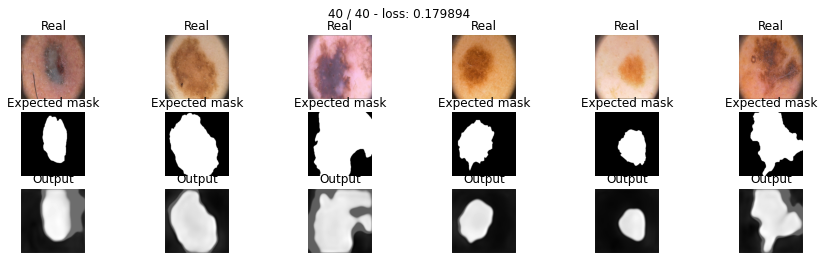

In [0]:
max_epochs = 40
optimizer = torch.optim.Adam(model_dice.parameters(),lr = 0.0001)
segnet_dice = train(model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val)

In [0]:
score_model(model_dice, iou_pytorch, data_val)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.7400000095367432

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [0]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    probability = torch.sigmoid(y_pred)
    pt = y_real*probability + (1 - y_real) * (1 - probability)

    #y_pred =  # hint: torch.clamp
    your_loss = (-(1-pt)**gamma * torch.log(pt + eps)).mean()
    return your_loss


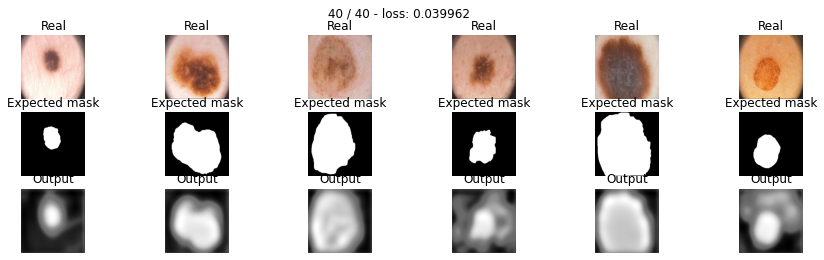

In [0]:
model_focal = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model_focal.parameters())
segnet_focal = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [0]:
score_model(model_focal, iou_pytorch, data_val)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.5140000104904174

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаю написать вам 1 функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Tversky loss
5) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

<div style="border-left: solid 6px #d6d6d6; padding: 10px; background-color: #eaeaea">
<b><i>Exercise:</i></b> Add the total variation term to the loss.</div>

In [0]:
#<TODO>

In [0]:
def tversky(y_real, y_pred, sm=1, beta=0.7, alpha=0.3):
    y_pred = torch.sigmoid(y_pred)
    tp = torch.sum(y_pred*y_real)
    fp = torch.sum(y_pred * torch.abs(1-y_real))
    fn = torch.sum((1-y_pred) * y_real)
    loss = tp / (tp + alpha*fp + beta*fn + sm)
    return (1-loss)

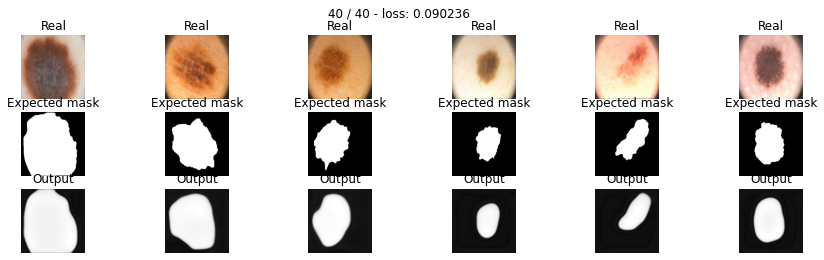

In [0]:
model_tversky = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model_tversky.parameters())
tversky = train(model_tversky, optimaizer, tversky, max_epochs, data_tr, data_val)

In [0]:
score_model(model_tversky, iou_pytorch, data_val)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.6020000219345093

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

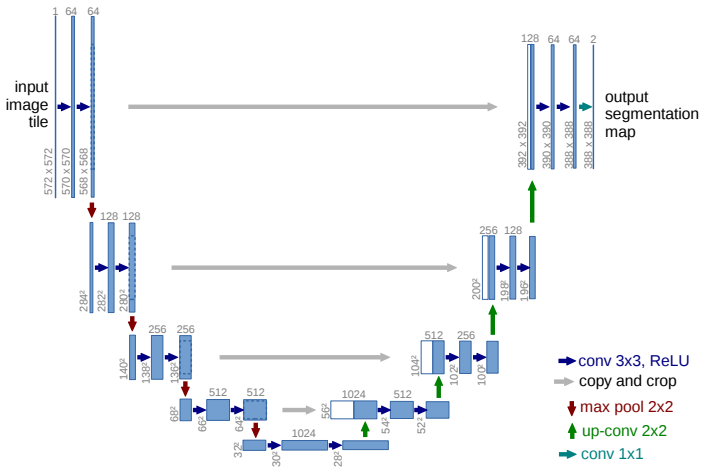

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [0]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32)
            )
        self.enc_conv0_1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32)
            )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
            )
        self.enc_conv1_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
            )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128)
            )
        self.enc_conv2_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128)
            )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256)
            )
        self.enc_conv3_1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256)
            )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) #32 -> 16

        # bottleneck
        self.bottleneck_conv =  nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear') # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128)
            )
        self.dec_conv0_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128)
            )
        
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear')# 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
            )
        self.dec_conv1_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
            )


        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear')  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32)
            )
        self.dec_conv2_1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32)
            )

        
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear')  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16)
            )
        self.dec_conv3_1 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        # encoder
        e0_c = F.relu(self.enc_conv0_1(F.relu(self.enc_conv0(x))))
        e0 = self.pool0(e0_c)
        e1_c = F.relu(self.enc_conv1_1(F.relu(self.enc_conv1(e0))))
        e1 = self.pool1(e1_c)
        e2_c = F.relu(self.enc_conv2_1(F.relu(self.enc_conv2(e1))))
        e2 = self.pool2(e2_c)
        e3_c = F.relu(self.enc_conv3_1(F.relu(self.enc_conv3(e2))))
        e3 = self.pool3(e3_c)

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        # print(e3_c.shape)
        # print(self.upsample0(b).shape)
        d0 = F.relu(self.dec_conv0_1(F.relu(self.dec_conv0(torch.cat((e3_c,self.upsample0(b)),1)))))
        d1 = F.relu(self.dec_conv1_1(F.relu(self.dec_conv1(torch.cat((e2_c,self.upsample1(d0)),1)))))
        d2 = F.relu(self.dec_conv2_1(F.relu(self.dec_conv2(torch.cat((e1_c,self.upsample2(d1)),1)))))
        d3 = self.dec_conv3_1(F.relu(self.dec_conv3(torch.cat((e0_c,self.upsample3(d2)),1))))
        return d3

In [0]:
unet_model = UNet().to(device)

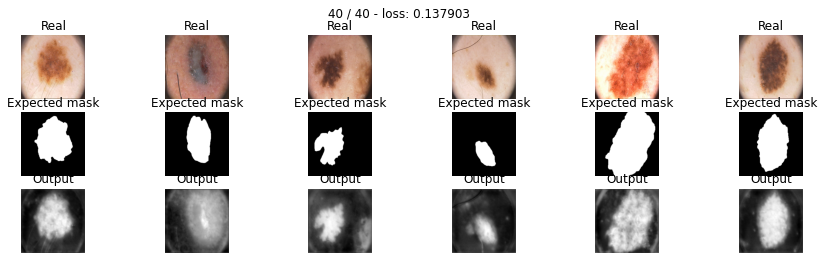

In [0]:
unet_bce = train(unet_model, optim.Adam(unet_model.parameters()), bce_loss, 40, data_tr, data_val)

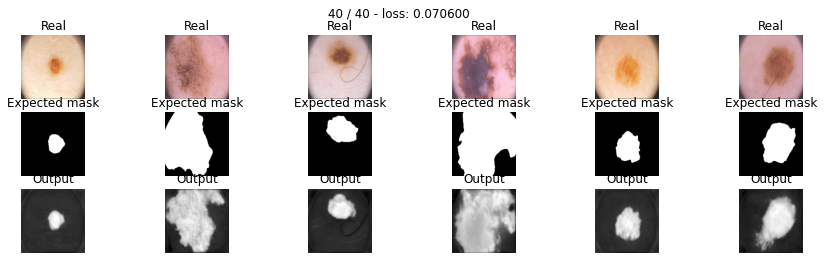

In [0]:
unet_dice = train(unet_model, optim.Adam(unet_model.parameters()), dice_loss, 40, data_tr, data_val)

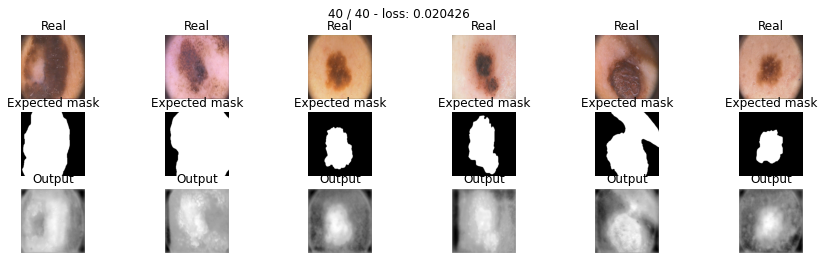

In [0]:
unet_focal = train(unet_model, optim.Adam(unet_model.parameters()), focal_loss, 40, data_tr, data_val)

In [0]:
score_model(unet_model, iou_pytorch, data_val)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.762000036239624

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [0]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32)
            )
        self.enc_conv0_1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32)
            )
        self.pool0 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=2, stride=2, padding=0)

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
            )
        self.enc_conv1_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
            )
        self.pool1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0)
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128)
            )
        self.enc_conv2_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128)
            )
        self.pool2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256)
            )
        self.enc_conv3_1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256)
            )
        self.pool3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0) #32 -> 16

        # bottleneck
        self.bottleneck_conv =  nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128)
            )
        self.dec_conv0_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128)
            )
        
        self.upsample1 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
            )
        self.dec_conv1_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
            )


        self.upsample2 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32)
            )
        self.dec_conv2_1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32)
            )

        
        self.upsample3 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=2, stride=2, padding=0)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16)
            )
        self.dec_conv3_1 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        # encoder
        e0_c = F.relu(self.enc_conv0_1(F.relu(self.enc_conv0(x))))
        e0 = self.pool0(e0_c)
        e1_c = F.relu(self.enc_conv1_1(F.relu(self.enc_conv1(e0))))
        e1 = self.pool1(e1_c)
        e2_c = F.relu(self.enc_conv2_1(F.relu(self.enc_conv2(e1))))
        e2 = self.pool2(e2_c)
        e3_c = F.relu(self.enc_conv3_1(F.relu(self.enc_conv3(e2))))
        e3 = self.pool3(e3_c)

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        # print(e3_c.shape)
        # print(self.upsample0(b).shape)
        d0 = F.relu(self.dec_conv0_1(F.relu(self.dec_conv0(torch.cat((e3_c,self.upsample0(b)),1)))))
        d1 = F.relu(self.dec_conv1_1(F.relu(self.dec_conv1(torch.cat((e2_c,self.upsample1(d0)),1)))))
        d2 = F.relu(self.dec_conv2_1(F.relu(self.dec_conv2(torch.cat((e1_c,self.upsample2(d1)),1)))))
        d3 = self.dec_conv3_1(F.relu(self.dec_conv3(torch.cat((e0_c,self.upsample3(d2)),1))))
        return d3

In [0]:
unet2_model = UNet2().to(device)


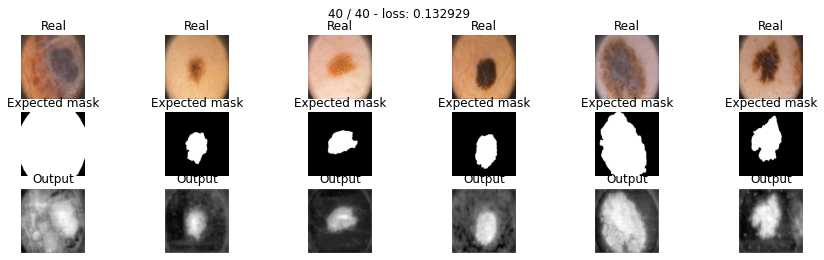

In [0]:
unet2_bce = train(unet2_model, optim.Adam(unet2_model.parameters()), bce_loss, 40, data_tr, data_val)

In [0]:
unet2_dice = train(unet2_model, optim.Adam(unet2_model.parameters()), dice_loss, 40, data_tr, data_val)

In [0]:
unet2_focal = train(unet2_model, optim.Adam(unet2_model.parameters()), focal_loss, 40, data_tr, data_val)

In [0]:
unet2_tversky = train(unet2_model, optim.Adam(unet2_model.parameters()), tversky_loss, 40, data_tr, data_val)

In [0]:
score_model(unet2_model, iou_pytorch, data_val)

0.7160000443458557

Сделайте вывод какая из моделей лучше

# Dilated convolutions [1 балл]

1.   List item
2.   List item






*   List item
*   List item


Еще один из вариантов делать upsampling и downsampling - использовать для этого *dilated convolutions*:


* Yu, Fisher, and Vladlen Koltun. "[Multi-scale context aggregation by dilated convolutions.](https://arxiv.org/pdf/1511.07122.pdf)" arXiv preprint arXiv:1511.07122 (2015).

попробуйте написать сеть DilatedUNet, которая использует в одной из предыдущих моделей dilated свертки.

In [0]:
class DilatedUNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm2d(32)
            )
        self.enc_conv0_1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm2d(32)
            )
        self.pool0 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3,stride=2, dilation=64),
            nn.BatchNorm2d(32)
            )
        # self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm2d(64)
            )
        self.enc_conv1_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm2d(64)
            )
        self.pool1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3,stride=2, dilation=32),
            nn.BatchNorm2d(64)
            )
        # self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm2d(128)
            )
        self.enc_conv2_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm2d(128)
            )
        self.pool2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3,stride=2, dilation=16),
            nn.BatchNorm2d(128)
            )
        # self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm2d(256)
            )
        self.enc_conv3_1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm2d(256)
            )
        self.pool3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2,stride=2, dilation=8),
            nn.BatchNorm2d(256)
            )
        # self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) #32 -> 16

        # bottleneck
        self.bottleneck_conv =  nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        # decoder (upsampling)
        # self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear') # 16 -> 32
        self.upsample0 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, dilation=8)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128)
            )
        self.dec_conv0_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128)
            )
        
        # self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear')# 32 -> 64
        self.upsample1 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, dilation=16)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
            )
        self.dec_conv1_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
            )


        # self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear')  # 64 -> 128
        self.upsample2 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, dilation=32)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32)
            )
        self.dec_conv2_1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32)
            )

        
        # self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear')  # 128 -> 256
        self.upsample3 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, dilation=64)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16)
            )
        self.dec_conv3_1 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        # encoder
        e0_c = F.relu(self.enc_conv0_1(F.relu(self.enc_conv0(x))))
        e0 = self.pool0(e0_c)
        e1_c = F.relu(self.enc_conv1_1(F.relu(self.enc_conv1(e0))))
        e1 = self.pool1(e1_c)
        e2_c = F.relu(self.enc_conv2_1(F.relu(self.enc_conv2(e1))))
        e2 = self.pool2(e2_c)
        e3_c = F.relu(self.enc_conv3_1(F.relu(self.enc_conv3(e2))))
        e3 = self.pool3(e3_c)

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        # print(e3_c.shape)
        # print(b.shape)
        # print(self.upsample0(b).shape)
        d0 = F.relu(self.dec_conv0_1(F.relu(self.dec_conv0(torch.cat((e3_c,self.upsample0(b)),1)))))
        d1 = F.relu(self.dec_conv1_1(F.relu(self.dec_conv1(torch.cat((e2_c,self.upsample1(d0)),1)))))
        d2 = F.relu(self.dec_conv2_1(F.relu(self.dec_conv2(torch.cat((e1_c,self.upsample2(d1)),1)))))
        d3 = self.dec_conv3_1(F.relu(self.dec_conv3(torch.cat((e0_c,self.upsample3(d2)),1))))
        return d3

In [0]:
model = DilatedUNet().to(device)

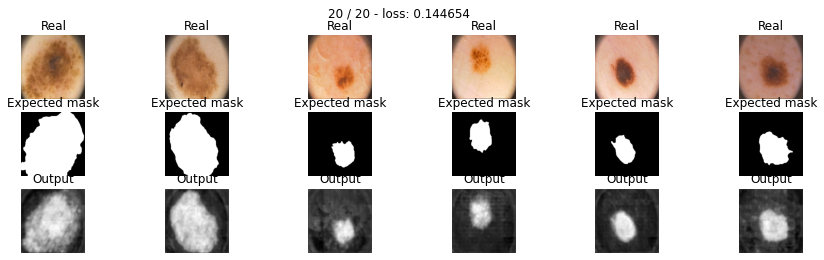

In [0]:
dil_unet_bce = train(model, optim.Adam(model.parameters()), bce_loss, 20, data_tr, data_val)

In [0]:
score_model(model, iou_pytorch, data_val)

0.7420000195503235

# Отчет (5 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 

Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверябщий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.



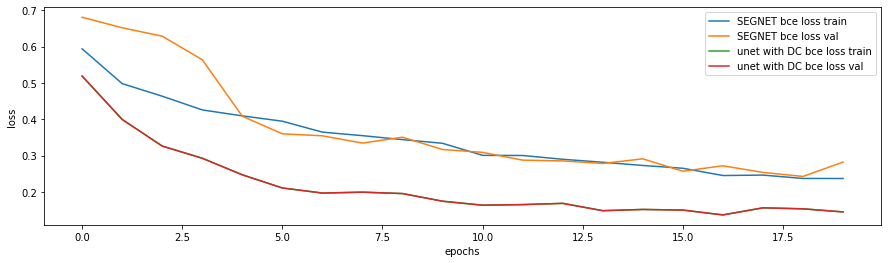

In [0]:
plt.plot(segnet_bce[0], label="SEGNET bce loss train")
plt.plot(segnet_bce[1], label="SEGNET bce loss val")

plt.plot(dil_unet_bce[0], label="unet with DC bce loss train")
plt.plot(dil_unet_bce[0], label="unet with DC bce loss val")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

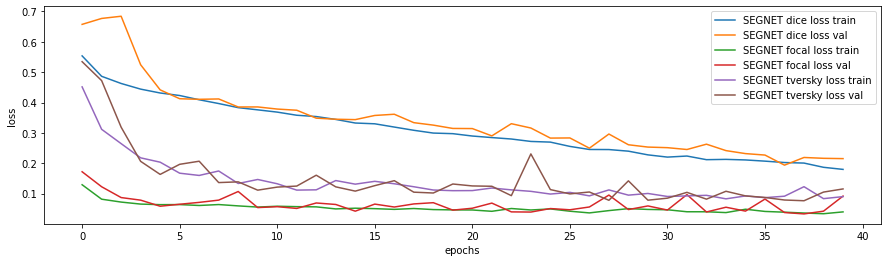

In [0]:
plt.plot(segnet_dice[0], label="SEGNET dice loss train")
plt.plot(segnet_dice[1], label="SEGNET dice loss val")

plt.plot(segnet_focal[0], label="SEGNET focal loss train")
plt.plot(segnet_focal[1], label="SEGNET focal loss val")

plt.plot(tversky[0], label="SEGNET tversky loss train")
plt.plot(tversky[1], label="SEGNET tversky loss val")

plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [0]:
UNET с DC, судя по всему, лучшая модель из реализованных. Лучший скор, лучшие графики лоссов